In [42]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
data = pd.read_csv('D:\MarketPricePrediction.csv')


In [43]:
data

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
0,ABOHAR(PB),January,2005,2350,404,493,446,PB,ABOHAR,January-2005
1,ABOHAR(PB),January,2006,900,487,638,563,PB,ABOHAR,January-2006
2,ABOHAR(PB),January,2010,790,1283,1592,1460,PB,ABOHAR,January-2010
3,ABOHAR(PB),January,2011,245,3067,3750,3433,PB,ABOHAR,January-2011
4,ABOHAR(PB),January,2012,1035,523,686,605,PB,ABOHAR,January-2012
...,...,...,...,...,...,...,...,...,...,...
10222,YEOLA(MS),December,2011,131326,282,612,526,MS,YEOLA,December-2011
10223,YEOLA(MS),December,2012,207066,485,1327,1136,MS,YEOLA,December-2012
10224,YEOLA(MS),December,2013,215883,472,1427,1177,MS,YEOLA,December-2013
10225,YEOLA(MS),December,2014,201077,446,1654,1456,MS,YEOLA,December-2014


In [44]:
label_encoder = LabelEncoder()
categorical_cols = ['market', 'state', 'city']
for col in categorical_cols:
    data[col] = label_encoder.fit_transform(data[col])



In [45]:
# Map month names to numeric values
month_map = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
}
data['month'] = data['month'].map(month_map)


In [46]:
data['date'] = pd.to_datetime(data[['year', 'month']].assign(day=1))


In [47]:
 data.drop(columns=['date'], inplace=True)

In [48]:
print(data.head())

   market  month  year  quantity  priceMin  priceMax  priceMod  state  city
0       0      1  2005      2350       404       493       446     16     0
1       0      1  2006       900       487       638       563     16     0
2       0      1  2010       790      1283      1592      1460     16     0
3       0      1  2011       245      3067      3750      3433     16     0
4       0      1  2012      1035       523       686       605     16     0


In [49]:
def plot_time_series(data, market_index):
    market_data = data[data['market'] == market_index]
    plt.figure(figsize=(14, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(market_data['date'], market_data['quantity'])
    plt.title(f'Market {market_index}: Quantity over Time')
    
    plt.subplot(2, 1, 2)
    plt.plot(market_data['date'], market_data['priceMin'], label='Min Price')
    plt.plot(market_data['date'], market_data['priceMax'], label='Max Price')
    plt.plot(market_data['date'], market_data['priceMod'], label='Mod Price')
    plt.title(f'Market {market_index}: Prices over Time')
    plt.legend()
    
    plt.tight_layout()
    plt.show()





In [50]:
# Create lag features and rolling statistics
def create_features(data):
    data['quarter'] = ((data['month'] - 1) // 3) + 1
    
    for lag in range(1, 13):
        data[f'quantity_lag_{lag}'] = data['quantity'].shift(lag)
        data[f'priceMin_lag_{lag}'] = data['priceMin'].shift(lag)
        data[f'priceMax_lag_{lag}'] = data['priceMax'].shift(lag)
        data[f'priceMod_lag_{lag}'] = data['priceMod'].shift(lag)
    
    data['quantity_roll_mean_3'] = data['quantity'].rolling(window=3).mean()
    data['priceMod_roll_mean_3'] = data['priceMod'].rolling(window=3).mean()
    
    data.dropna(inplace=True)
    
    return data

In [51]:
# Apply feature engineering
data = create_features(data)
print(data.head())

    market  month  year  quantity  priceMin  priceMax  priceMod  state  city  \
12       0      2  2012       675       510       650       570     16     0   
13       0      2  2013       845      1400      1843      1629     16     0   
14       0      2  2014      1115       831      1163       983     16     0   
15       0      2  2015      1115      1200      1946      1688     16     0   
16       0      3  2005       900       281       357       322     16     0   

    quarter  ...  quantity_lag_11  priceMin_lag_11  priceMax_lag_11  \
12        1  ...            900.0            487.0            638.0   
13        1  ...            790.0           1283.0           1592.0   
14        1  ...            245.0           3067.0           3750.0   
15        1  ...           1035.0            523.0            686.0   
16        1  ...            675.0           1327.0           1900.0   

    priceMod_lag_11  quantity_lag_12  priceMin_lag_12  priceMax_lag_12  \
12            563.

In [52]:
# Apply feature engineering
data = create_features(data)
print(data.head())

    market  month  year  quantity  priceMin  priceMax  priceMod  state  city  \
24       0      4  2006      2100       326       400       366     16     0   
25       0      4  2010       840       466       755       611     16     0   
26       0      4  2011       495       436       625       553     16     0   
27       0      4  2012      2028       486       709       573     16     0   
28       0      4  2013       932       892      1225      1035     16     0   

    quarter  ...  quantity_lag_11  priceMin_lag_11  priceMax_lag_11  \
24        2  ...            845.0           1400.0           1843.0   
25        2  ...           1115.0            831.0           1163.0   
26        2  ...           1115.0           1200.0           1946.0   
27        2  ...            900.0            281.0            357.0   
28        2  ...           3185.0            359.0            425.0   

    priceMod_lag_11  quantity_lag_12  priceMin_lag_12  priceMax_lag_12  \
24           1629.

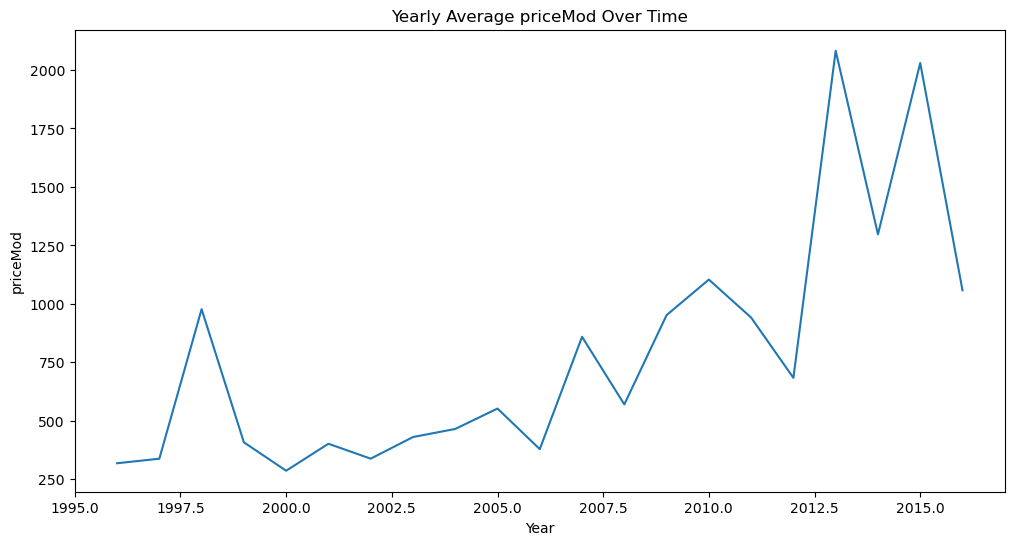

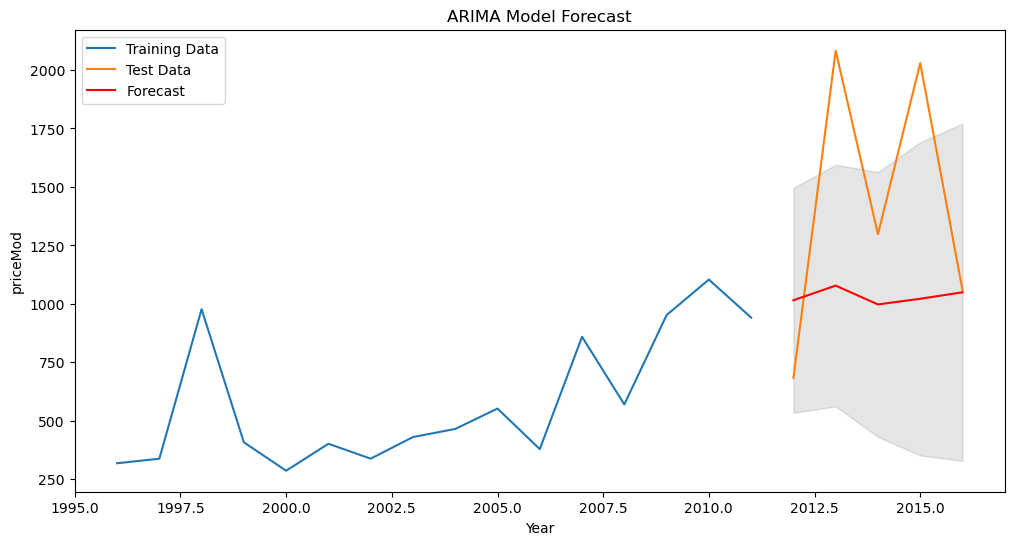

Mean Squared Error: 444983.78478638537


In [53]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")



# Select the numeric columns for ARIMA modeling
data_numeric = data[['priceMod', 'year']]

# Group by year and calculate the mean priceMod
data_yearly = data_numeric.groupby('year').mean()

# Reset index to make 'year' a regular column
data_yearly.reset_index(inplace=True)

# Visualize the time series
plt.figure(figsize=(12, 6))
plt.plot(data_yearly['year'], data_yearly['priceMod'])
plt.title('Yearly Average priceMod Over Time')
plt.xlabel('Year')
plt.ylabel('priceMod')
plt.show()

# Split the data into training and testing sets
train_size = int(len(data_yearly) * 0.8)
train, test = data_yearly[:train_size], data_yearly[train_size:]

# Fit the ARIMA model
model = ARIMA(train['priceMod'], order=(5, 1, 0))  # (p, d, q) parameters need tuning
model_fit = model.fit()

# Make predictions
forecast = model_fit.forecast(steps=len(test))
conf_int = model_fit.get_forecast(steps=len(test)).conf_int()

# Create a DataFrame to hold the actual and predicted values
forecast_index = test.index
forecast_series = pd.Series(forecast, index=forecast_index)
lower_series = pd.Series(conf_int.iloc[:, 0], index=forecast_index)
upper_series = pd.Series(conf_int.iloc[:, 1], index=forecast_index)

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(train['year'], train['priceMod'], label='Training Data')
plt.plot(test['year'], test['priceMod'], label='Test Data')
plt.plot(test['year'], forecast_series, label='Forecast', color='red')
plt.fill_between(test['year'], lower_series, upper_series, color='k', alpha=0.1)
plt.title('ARIMA Model Forecast')
plt.xlabel('Year')
plt.ylabel('priceMod')
plt.legend()
plt.show()

# Evaluate the model
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test['priceMod'], forecast_series)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 444983.78478638537


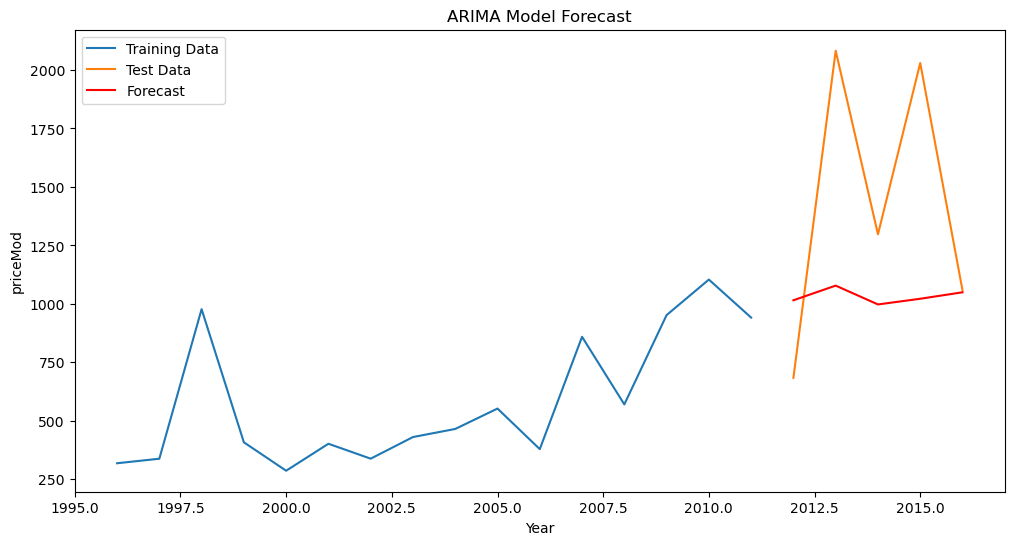

In [54]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error



# Select the numeric columns for ARIMA modeling
data_numeric = data[['priceMod', 'year']]

# Group by year and calculate the mean priceMod
data_yearly = data_numeric.groupby('year').mean()

# Reset index to make 'year' a regular column
data_yearly.reset_index(inplace=True)

# Split the data into training and testing sets
train_size = int(len(data_yearly) * 0.8)
train, test = data_yearly[:train_size], data_yearly[train_size:]

# Fit the ARIMA model
model = ARIMA(train['priceMod'], order=(5, 1, 0))  # (p, d, q) parameters need tuning
model_fit = model.fit()

# Make predictions
forecast = model_fit.forecast(steps=len(test))

# Calculate Mean Squared Error
mse = mean_squared_error(test['priceMod'], forecast)
print(f'Mean Squared Error: {mse}')

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(train['year'], train['priceMod'], label='Training Data')
plt.plot(test['year'], test['priceMod'], label='Test Data')
plt.plot(test['year'], forecast, label='Forecast', color='red')
plt.title('ARIMA Model Forecast')
plt.xlabel('Year')
plt.ylabel('priceMod')
plt.legend()
plt.show()


In [55]:
import numpy as np

# Calculate R-squared manually
def r_squared(y_true, y_pred):
    y_mean = np.mean(y_true)
    ss_total = np.sum((y_true - y_mean) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    return 1 - (ss_residual / ss_total)

# Calculate R-squared for the ARIMA model
r2 = r_squared(test['priceMod'], forecast)
print(f'R-squared Score: {r2}')


R-squared Score: -0.4846478018172784


Mean Squared Error after noise removal: 444983.78478638537
R-squared Score after noise removal: -0.4846478018172784


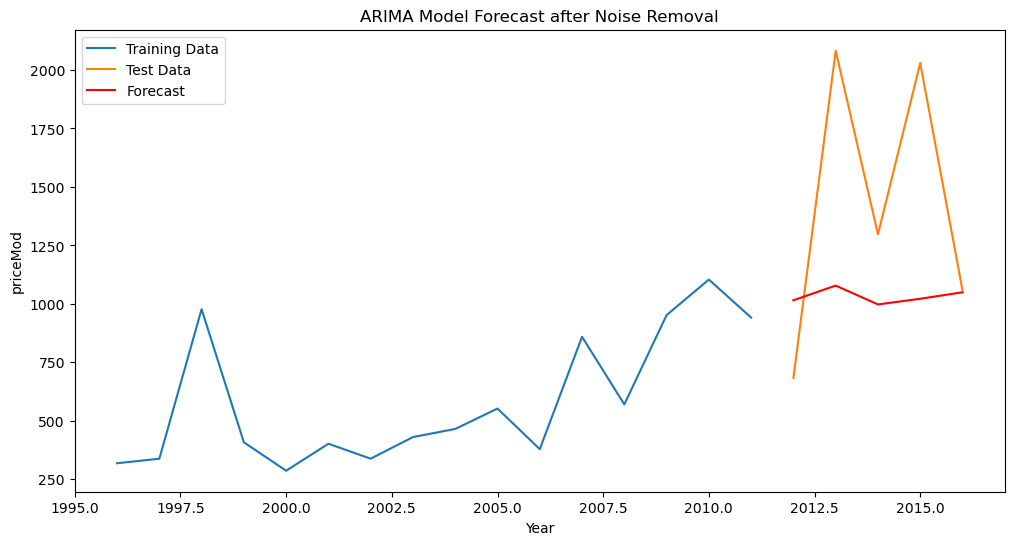

In [41]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error



# Select the numeric columns for ARIMA modeling
data_numeric = data[['priceMod', 'year']]

# Group by year and calculate the mean priceMod
data_yearly = data_numeric.groupby('year').mean()

# Reset index to make 'year' a regular column
data_yearly.reset_index(inplace=True)

# Remove outliers or noise
# For example, you can use z-score to detect and remove outliers
z_scores = (data_yearly['priceMod'] - data_yearly['priceMod'].mean()) / data_yearly['priceMod'].std()
data_yearly_no_outliers = data_yearly[(z_scores < 3)]  # Keep only data points within 3 standard deviations

# Split the data into training and testing sets
train_size = int(len(data_yearly_no_outliers) * 0.8)
train, test = data_yearly_no_outliers[:train_size], data_yearly_no_outliers[train_size:]

# Fit the ARIMA model
model = ARIMA(train['priceMod'], order=(5, 1, 0))  # (p, d, q) parameters need tuning
model_fit = model.fit()

# Make predictions
forecast = model_fit.forecast(steps=len(test))

# Calculate Mean Squared Error
mse = mean_squared_error(test['priceMod'], forecast)
print(f'Mean Squared Error after noise removal: {mse}')

# Calculate R-squared manually
def r_squared(y_true, y_pred):
    y_mean = np.mean(y_true)
    ss_total = np.sum((y_true - y_mean) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    return 1 - (ss_residual / ss_total)

# Calculate R-squared for the ARIMA model
r2 = r_squared(test['priceMod'], forecast)
print(f'R-squared Score after noise removal: {r2}')

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(train['year'], train['priceMod'], label='Training Data')
plt.plot(test['year'], test['priceMod'], label='Test Data')
plt.plot(test['year'], forecast, label='Forecast', color='red')
plt.title('ARIMA Model Forecast after Noise Removal')
plt.xlabel('Year')
plt.ylabel('priceMod')
plt.legend()
plt.show()
